<a href="https://colab.research.google.com/github/henriqueburis/Image_Classification_model_VGG16_from_scratch/blob/main/Classification_vgg16from_scrapt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Deep learning CNN-VGG16 from scrapt

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!rm -rf /content/UCMerced_LandUse_pixforce_threeClasse

In [ ]:
!unzip /content/drive/MyDrive/UCMerced_LandUse_pixforce_threeClasse.zip

In [ ]:
!pip install tensorboardX

In [4]:
import os
import torch
import argparse
import numpy as np
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader, TensorDataset
from tensorboardX import SummaryWriter
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from sklearn.manifold import TSNE
import seaborn as sns

In [18]:
print("==> Parametre data")
img_size = 227
batch_size = 32
batch_size_inferencia = 1
n_classe = 0
epoch = 200

path_train = "/content/UCMerced_LandUse_pixforce_threeClasse/train"
path_test = "/content/UCMerced_LandUse_pixforce_threeClasse/Images"
save_dir = "/content/drive/MyDrive/results"

==> Parametre data


In [6]:
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.Resize((img_size,img_size)),
    #transforms.RandomCrop(32, padding=4), # testar sem o randomcrop.
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.Resize((img_size,img_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


trainset = datasets.ImageFolder(os.path.abspath(path_train), transform=transform_train)

train, valid = torch.utils.data.random_split(trainset,[243,27]) #10%test

train_loader = torch.utils.data.DataLoader(train,
                                          batch_size=batch_size,
                                          shuffle=True, num_workers=0)

val_loader = torch.utils.data.DataLoader(valid,
                                          batch_size=batch_size,
                                          shuffle=False, num_workers=0)

testset = datasets.ImageFolder(os.path.abspath(path_test), transform=transform_test)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size_inferencia,
                                         shuffle=False, num_workers=0)



==> Preparing data..


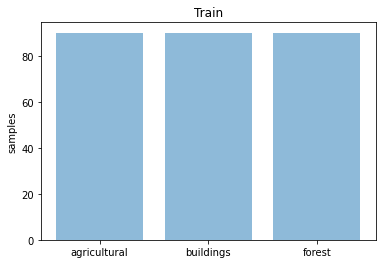

Classe do treinamento==)> ['agricultural', 'buildings', 'forest']
Num_ Classe==)> 3
Dataset Train 243
Dataset Val 27
------------------------------------------------
==> Preparing data Done..


In [7]:
classes =  train_loader.dataset.dataset.classes
num_label = train_loader.dataset.dataset.targets
n_classe = len(classes)
a = num_label.count(0)
b = num_label.count(1)
c = num_label.count(2)
y_pos = np.arange(len(classes))
performance = [a,b,c]
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, classes)
plt.ylabel('samples')
plt.title('Train')
plt.savefig('balanced.png')
plt.show()
print("Classe do treinamento==)>",classes)
print("Num_ Classe==)>",n_classe)
print("Dataset Train",len(train_loader.dataset.indices))
print("Dataset Val",len(val_loader.dataset.indices))
print("------------------------------------------------")
print('==> Preparing data Done..')

In [21]:
class vgg16scratch(nn.Module):
    def __init__(self, num_classes=0):
        super(vgg16scratch, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),nn.ReLU(),
            nn.BatchNorm2d(64), 
            nn.MaxPool2d((2,2), stride=(2,2)), # pool de janela quadrada de tamanho = 2, passo = 2
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d((2,2), stride=(2,2)), # pool de janela quadrada de tamanho = 2, passo = 2
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d((2,2), stride=(2,2)), # pool de janela quadrada de tamanho = 2, passo = 2
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),nn.ReLU(),
            nn.MaxPool2d((2,2), stride=(2,2)), # pool de janela quadrada de tamanho = 2, passo = 2
        )
        self.layer5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.MaxPool2d((2,2), stride=(2,2)), # pool de janela quadrada de tamanho = 2, passo = 2
        )
        self.fc = nn.Sequential(
            nn.Linear(7*7*512, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.view(out.size(0), -1)
        #print(out.shape)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [22]:
print('==> Building model..')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

net = vgg16scratch(n_classe).to(device)

print(net)

net = net.to(device)

print("-------------------")
print(device)

==> Building model..
vgg16scratch(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
 

https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html

In [10]:
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

criterion_cnn = nn.CrossEntropyLoss()
optimizer_cnn = optim.Adam(net.parameters(), lr=0.00001)

In [11]:
def save_model(model):
    torch.save(model.state_dict(), save_dir + "/""pixforce_model.pt")

def CreateDir(path):
        try:
                os.mkdir(path)
        except OSError as error:
                print(error)

In [12]:
CreateDir(save_dir)

[Errno 17] File exists: '/content/drive/MyDrive/results'


In [13]:
print('==> Preparing tensorboard..')
writer = SummaryWriter(save_dir)

==> Preparing tensorboard..


In [14]:
def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer_cnn.zero_grad()
        outputs = net(inputs)
        loss = criterion_cnn(outputs, targets)# criterion
        loss.backward()
        optimizer_cnn.step()
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        writer.add_scalar('Training/ACC_',100.*correct/total, (epoch*len(train_loader.dataset)/batch_size)+batch_idx)
        writer.add_scalar('Training/loss_',train_loss/(batch_idx+1),(epoch*len(train_loader.dataset)/batch_size)+batch_idx)
    print('\n %d',correct/total*100)
    writer.add_scalar('Training/ACC',correct/total*100, epoch)

In [15]:
def val():
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            _, predicted = outputs.max(1)

            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    acc = 100.*correct/total
    print("ACC_test",acc)

In [17]:
for epoch in range(0, epoch):
  train(epoch)

#print("--------------")
val()


Epoch: 0
torch.Size([32, 25088])
torch.Size([32, 25088])
torch.Size([32, 25088])
torch.Size([32, 25088])
torch.Size([32, 25088])
torch.Size([32, 25088])
torch.Size([32, 25088])
torch.Size([19, 25088])

 %d 99.58847736625515

Epoch: 1
torch.Size([32, 25088])
torch.Size([32, 25088])
torch.Size([32, 25088])
torch.Size([32, 25088])
torch.Size([32, 25088])
torch.Size([32, 25088])
torch.Size([32, 25088])
torch.Size([19, 25088])

 %d 99.58847736625515

Epoch: 2
torch.Size([32, 25088])
torch.Size([32, 25088])
torch.Size([32, 25088])
torch.Size([32, 25088])
torch.Size([32, 25088])
torch.Size([32, 25088])
torch.Size([32, 25088])
torch.Size([19, 25088])

 %d 99.58847736625515

Epoch: 3
torch.Size([32, 25088])
torch.Size([32, 25088])
torch.Size([32, 25088])
torch.Size([32, 25088])
torch.Size([32, 25088])
torch.Size([32, 25088])
torch.Size([32, 25088])
torch.Size([19, 25088])

 %d 100.0

Epoch: 4
torch.Size([32, 25088])
torch.Size([32, 25088])
torch.Size([32, 25088])
torch.Size([32, 25088])
torch.